In [16]:
import h5py
import numpy as np
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants 
from astropy.modeling import models, fitting
from scipy.stats import gaussian_kde


from vespa_update import trilegal
import os
p = os.environ['PATH']
pv = os.path.join(os.getcwd(),'vespa_update')
p2 = pv+':'+p
os.environ['PATH'] = p2

import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBWorkerNew import LSSTEBWorker
from OpSim import OpSim
from TRILEGAL import TRILEGAL

from matplotlib import pyplot as plt
#%matplotlib notebook
%matplotlib inline

#%load_ext autoreload
#%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get the field centers and number of observations from OpSim

In [17]:
#https://www.lsst.org/scientists/simulations/opsim/summary-table-column-descriptions-v335
#http://ops2.lsst.org/docs/current/architecture.html
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/minion_1016_sqlite.db'
OpS.getAllOpSimFields()

getting OpSim fields...
have summary cursor.
have field cursor.
returned 5292 fields


/Users/ageller/anaconda3/lib/python3.7/site-packages/matplotlib/projections/geo.py:414: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


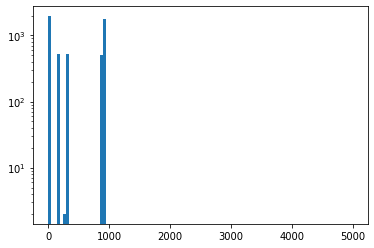

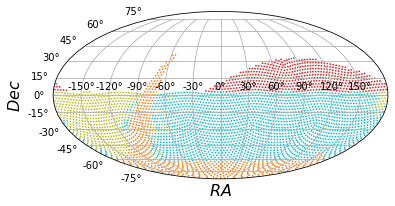

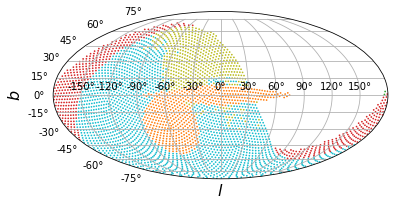

In [18]:
coords = SkyCoord(OpS.RA, OpS.Dec, unit=(u.degree, u.degree),frame='icrs')
lGal = coords.galactic.l.wrap_at(180.*u.degree).degree
bGal = coords.galactic.b.wrap_at(180.*u.degree).degree

raGal = coords.icrs.ra.wrap_at(180.*u.degree).degree
decGal = coords.icrs.dec.wrap_at(180.*u.degree).degree

f,ax = plt.subplots()
ax.hist(OpS.Nobs,bins = 100, range=(0,5000))
ax.set_yscale('log', nonposy='clip')

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$RA$",fontsize=16)
ax.set_ylabel(r"$Dec$",fontsize=16)
xx = np.where(OpS.Nobs > 0)
ax.scatter(raGal[xx]*np.pi/180.,decGal[xx]*np.pi/180., s = 0.5, c=OpS.Nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)

f, ax = plt.subplots(subplot_kw={'projection': "mollweide"})
ax.grid(True)
ax.set_xlabel(r"$l$",fontsize=16)
ax.set_ylabel(r"$b$",fontsize=16)
ax.scatter(lGal[xx]*np.pi/180.,bGal[xx]*np.pi/180., s = 0.5, c=OpS.Nobs[xx], cmap='tab10', alpha = 1, vmin=0, vmax=1000)


### Get the TRILEGAL simulation at each OpSim field

*Just look at the first one for a test*

In [19]:
galaxy = TRILEGAL()
galaxy.RA = OpS.RA[0]
galaxy.Dec = OpS.Dec[0]
galaxy.fieldID = OpS.fieldID[0]
galaxy.tmpfname = 'trilegal.grid.id' + str(galaxy.fieldID) + '.h5'
galaxy.tmpdir = 'grid'
galaxy.setModel()

# #this area is a bit odd because we're on a sphere... 
# area = 10.
# maglim = 26
# sigma_AV = 0.1 #default
# binaries = False
# filterset = 'lsst' #kepler_2mass

# for r,d,f in zip(RA,Dec,fID):
#     print(r,d,f)
#     filename = 'trilegal.grid.id'+str(f)
#     x = trilegal.get_trilegal(filename, r, d, folder='grid', galactic=False, \
#                                   filterset=filterset, area=area, maglim=maglim, binaries=binaries, \
#                                   trilegal_version='1.6', sigma_AV=sigma_AV, convert_h5=True)
    
#     break

downloading TRILEGAL model for ID=1.0, RA=0.0, DEC=-90.0
get_trilegal 1.6 302.931925 -27.128252 10.000000 0 0.504 0.10 lsst 1 26.0 grid/trilegal.grid.id1.0.h5.dat grid


/Volumes/highnoon2go/highnoon/WORK/LSST/onGitHub/EBLSST/testing/TRILEGAL/vespa_update/trilegal.py:100: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table(outfile, sep='\s+', skipfooter=1, engine='python')


## Look through the TRILEGAL model to test

In [20]:
df = galaxy.model
#df = df.sample(frac=1)
#dist = 10.**(df['m-M0'].values/5.) * 10.# *u.parsec
logDist = np.log10( 10.**(df['m-M0'].values/5.) *10. / 1000.) #log(d [kpc])
df['logDist'] = logDist

print(df)

data = np.vstack((df['Mact'].values, df['logL'].values, df['logTe'].values, df['logg'].values))
TRILEGAL_KDE = gaussian_kde(data)


        Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
0        1    9.75  -0.01  0.65197 -0.962  3.637  4.710  11.2  0.511    0.0   
1        2   10.07  -1.29  0.70318 -0.330  3.762  4.608  11.5  0.454    0.0   
2        1    9.51   0.11  0.41702 -1.591  3.576  4.900  10.3  0.461    0.0   
3        2   10.07  -1.17  0.50812 -1.115  3.658  4.838  14.3  0.540    0.0   
4        1    9.75  -0.37  0.32065 -1.771  3.586  5.004  11.8  0.469    0.0   
5        1    9.89  -0.47  0.77090 -0.399  3.729  4.585  10.4  0.507    0.0   
6        1    9.89  -0.29  0.58244 -1.069  3.635  4.759  13.2  0.503    0.0   
7        1    8.93   0.05  0.26434 -2.011  3.551  5.023   8.2  0.416    0.0   
8        3   10.07  -2.81  0.67265 -0.382  3.766  4.657  14.8  0.563    0.0   
9        1    9.71  -0.45  0.34412 -1.683  3.596  4.989  10.1  0.461    0.0   
10       2   10.05  -1.25  0.36184 -1.527  3.630  4.990  13.3  0.446    0.0   
11       1    9.91  -0.19  0.80174 -0.411  3.717  4.

*Check some plots*

207577


Text(0.5, 0, '[M/H]')

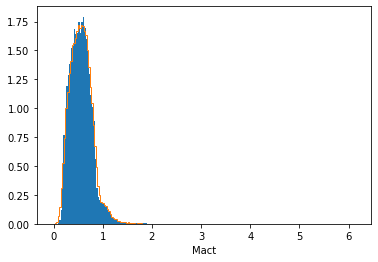

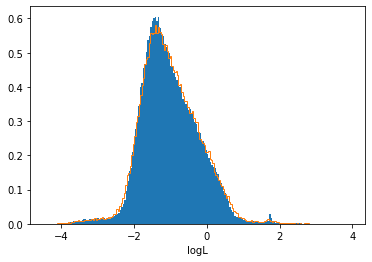

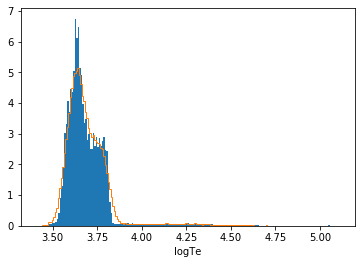

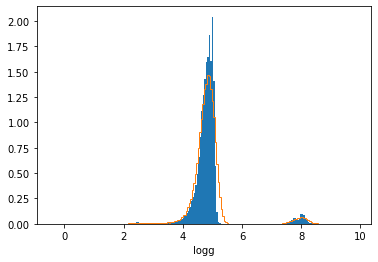

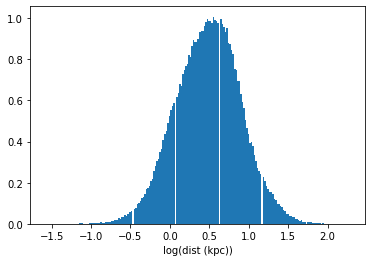

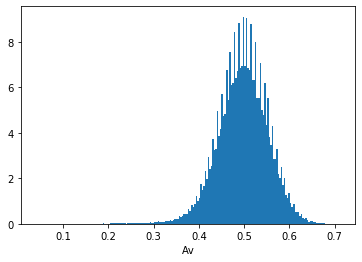

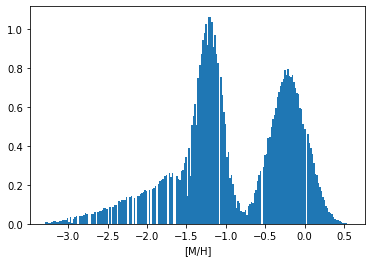

In [21]:
print(len(df))
nbins = 200

sample = TRILEGAL_KDE.resample(size=int(1e5))

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['Mact'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[0,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('Mact')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logL'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[1,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logL')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logTe'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[2,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logTe')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logg'].values, bins=nbins, density=True)
n, bins, patches = ax.hist(sample[3,:], bins=nbins, density=True, histtype='step')
ax.set_xlabel('logg')



f,ax = plt.subplots()
n, bins, patches = ax.hist(df['logDist'].values, bins=nbins, density=True)
ax.set_xlabel('log(dist (kpc))')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['Av'].values, bins=nbins, density=True)
ax.set_xlabel('Av')

f,ax = plt.subplots()
n, bins, patches = ax.hist(df['[M/H]'].values, bins=nbins, density=True)
ax.set_xlabel('[M/H]')

# f,ax = plt.subplots()
# n, bins, patches = ax.hist(df['Av'].values, bins=nbins, density=True)
# ax.set_xlabel('Av')

## Now create a set of binaries that looks like a field population

In [22]:
#for the binary fraction
def fitRagfb():
    x = [0.05, 0.1, 1, 8, 15]  #estimates of midpoints in bins, and using this: https://sites.uni.edu/morgans/astro/course/Notes/section2/spectralmasses.html
    y = [0.20, 0.35, 0.50, 0.70, 0.75]
    init = models.PowerLaw1D(amplitude=0.5, x_0=1, alpha=-1.)
    fitter = fitting.LevMarLSQFitter()
    fit = fitter(init, x, y)

    return fit

#uniform distribution for mass ratio
def getq():
    return np.random.random()

#uniform distribution for eccentricity
def getecc():
    return np.random.random()

#log-normal distribution for period
def getlogp():
    return np.random.normal(loc=5.03, scale=2.28)

def getRad(logg, m):
    #g = GM/r**2
    g = 10.**logg * u.cm/u.s**2.
    r = ((constants.G*m*u.Msun/g)**0.5).decompose().to(u.Rsun).value
    return r

#test for the Sun
#print(getRad(4.43, 1)) 

### Select random stars from TRILEGAL, weighted by the binary fraction, and create the binaries

*And put it in the format that is expected by our code:*

**m1, m2, logp, ecc, rad1, rad2, Lum1, Lum2, xGX, yGX, zGX, dist_kpc, inc, OMEGA, omega**


In [23]:
fbFit= fitRagfb()
#print(fbFit)


Nbins = 400
mTol = 0.001 #tolerance on the mass to draw from the trilegal sample

m1 = []
rad1 = []
lum1 = []
teff1 = []

m2 = []
rad2 = []
lum2 = []
teff2 = []

logp = []
ecc = []

dist = []
Av = [] 
MH = []
while len(m1) < Nbins:
    s = df.sample()
    fb = fbFit(s['m_ini'].iloc[0]) #I think I should base this on the initial mass, since these binary fractions are for unevolved stars
    xx = np.random.random()
    if (xx < fb):
        m1.append(s['Mact'].iloc[0])
        rad1.append(getRad(s['logg'].iloc[0], s['Mact'].iloc[0]))
        lum1.append(10.**s['logL'].iloc[0])
        teff1.append(10.**s['logTe'].iloc[0])
        
        m2Use = s['Mact'].iloc[0]*getq()
        #rad2, lum2, teff2 need to be drawn from TRILEGAL given m2
        done = False
        mTolUse = mTol
        while (not done):
            df_sort = df.loc[ (df['Mact'] - m2Use).abs() < mTolUse]
            if (len(df_sort) > 0):
                done = True
                ss = df_sort.sample()
                m2.append(ss['Mact'].iloc[0])
                rad2.append(getRad(ss['logg'].iloc[0], ss['Mact'].iloc[0]))
                lum2.append(10.**ss['logL'].iloc[0])
                teff2.append(10.**ss['logTe'].iloc[0])
            else:
                #print('WARNING: failed to reach tolerance', mTolUse)
                mTolUse *=2
        
        logp.append(getlogp())
        ecc.append(getecc())
        
        dist.append(10.**s['logDist'].iloc[0])
        Av.append(s['Av'].iloc[0]) #is this measure OK?
        MH.append(s['[M/H]'].iloc[0])

m1 = np.array(m1)
rad1 = np.array(rad1)
lum1 = np.array(lum1)
m2 = np.array(m2)
rad2 = np.array(rad2)
lum2 = np.array(lum2)
logp = np.array(logp)
ecc = np.array(ecc)
dist = np.array(dist)
Av = np.array(Av)
MH = np.array(MH)

#random angles
inc = np.arccos(2.*np.random.uniform(0,1,Nbins) - 1.)
omega = np.random.uniform(0,2*np.pi,Nbins)
OMEGA = np.random.uniform(0,2*np.pi,Nbins)
x = np.zeros(Nbins)
k1 = np.ones(Nbins) #dummy values
k2 = np.ones(Nbins) #dummy values

#we don't need position, but we do need distance
output = np.vstack( (m1, m2, logp, ecc, rad1, rad2, lum1, lum2, x, x, x, dist, inc, OMEGA, omega, Av, MH, teff1, teff2, k1, k2) ).T
#print(output)

/Users/ageller/anaconda3/lib/python3.7/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


Text(0.5, 0, 'ecc')

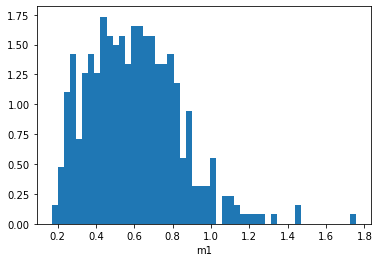

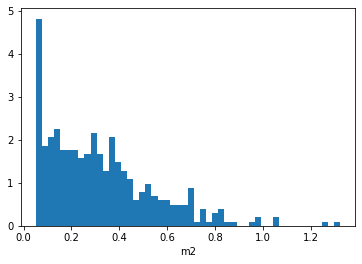

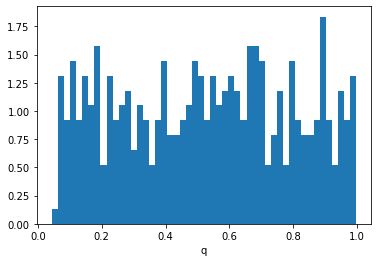

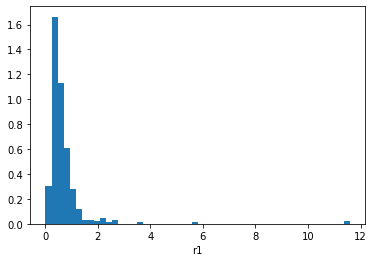

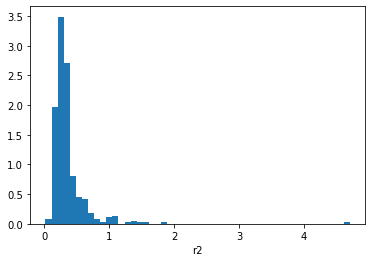

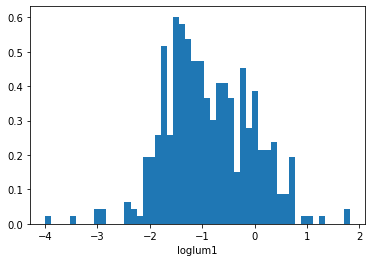

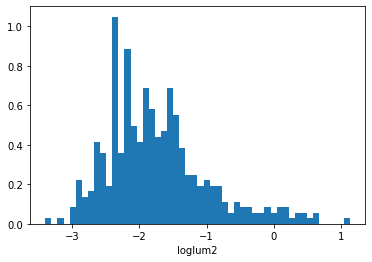

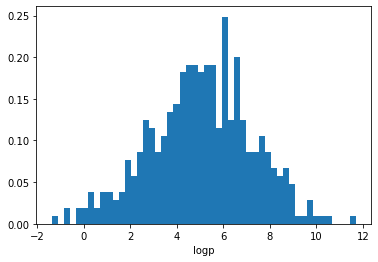

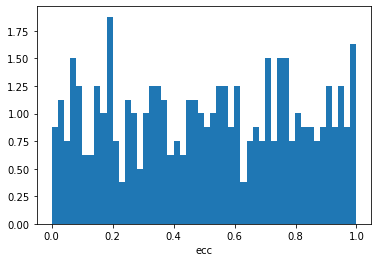

In [24]:
nbins = 50
f,ax = plt.subplots()
n, bins, patches = ax.hist(m1, bins=nbins, density=True)
ax.set_xlabel('m1')

f,ax = plt.subplots()
n, bins, patches = ax.hist(m2, bins=nbins, density=True)
ax.set_xlabel('m2')

f,ax = plt.subplots()
n, bins, patches = ax.hist(m2/m1, bins=nbins, density=True)
ax.set_xlabel('q')

f,ax = plt.subplots()
n, bins, patches = ax.hist(rad1, bins=nbins, density=True)
ax.set_xlabel('r1')

f,ax = plt.subplots()
n, bins, patches = ax.hist(rad2, bins=nbins, density=True)
ax.set_xlabel('r2')

f,ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lum1), bins=nbins, density=True)
ax.set_xlabel('loglum1')

f,ax = plt.subplots()
n, bins, patches = ax.hist(np.log10(lum2), bins=nbins, density=True)
ax.set_xlabel('loglum2')

f,ax = plt.subplots()
n, bins, patches = ax.hist(logp, bins=nbins, density=True)
ax.set_xlabel('logp')

f,ax = plt.subplots()
n, bins, patches = ax.hist(ecc, bins=nbins, density=True)
ax.set_xlabel('ecc')


## Now do this all with the worker code

In [25]:
OpSimi = 389
worker = LSSTEBWorker()
worker.OpSim = OpS
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.initialize(OpSimi)

total number of OpSim observation dates (all filters) = 906.0


True

In [26]:
worker.galDir = 'grid'
worker.getGalaxy(OpSimi, deleteModel = False)

downloading TRILEGAL model for ID=390.0, RA=152.918441772461, DEC=-58.3803367614746
get_trilegal 1.6 283.253352 -1.750421 10.000000 0 7.481 0.10 lsst 1 26.0 grid/TRILEGAL_model_fID390.h5.dat grid


In [27]:
print(worker.Galaxy.model.sample())

        Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0    Av  m2/m1  \
203926   1    9.23   0.07  1.14312  0.206  3.783  4.369  12.0  4.32    0.0   

          mbol   u_mag   g_mag   r_mag   i_mag   z_mag   Y_mag   Mact  logDist  
203926  16.255  24.395  21.602  19.887  18.983  18.291  17.912  1.143      0.4  


In [29]:
worker.n_bin = 100
gxDat = worker.sampleGalaxy(OpSimi)

creating binaries...
        Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
11502    1    9.77  -0.11  0.50010 -1.347  3.603  4.843   6.8  0.302    0.0   
18678    1    9.43  -0.17  0.50007 -1.345  3.606  4.851  10.1  1.506    0.0   
19527    1    9.43  -0.01  0.49970 -1.380  3.597  4.850  10.5  1.821    0.0   
21203    1    9.43   0.11  0.49957 -1.391  3.593  4.844   9.9  1.314    0.0   
23267    1    9.03  -0.09  0.49959 -1.369  3.601  4.857   7.4  0.471    0.0   
25818    1    8.77   0.11  0.49989 -1.397  3.592  4.849  10.4  1.481    0.0   
30243    1    9.33  -0.07  0.49976 -1.369  3.600  4.853  10.4  1.632    0.0   
32142    1    9.25  -0.17  0.49974 -1.349  3.606  4.855  10.4  2.045    0.0   
33712    2   10.07  -0.85  0.50031 -1.176  3.646  4.842  10.9  2.407    0.0   
40810    1    9.63  -0.11  0.50039 -1.351  3.603  4.846  10.2  1.671    0.0   
48400    1    9.31   0.41  0.49965 -1.398  3.589  4.839  10.5  1.765    0.0   
54613    1    9.81  -0.31  0.50

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
2.0
3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
2.0
3.0
4.0
5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


3.4700000000000006 90.0 0.10861786953095484 0.06047793175763162 0.33698354839297084 0.634441087613293


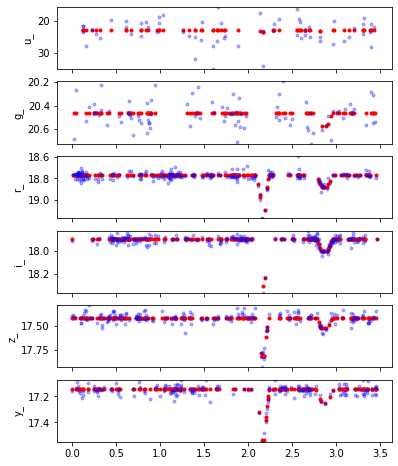

In [36]:
i = 7
#line = output[i]
line = gxDat[i]

#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)

EB = worker.getEB(line, OpSimi=OpSimi)

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

fig,ax = plt.subplots(6,1, figsize=(6,8), sharex = True)
for i,f in enumerate(worker.filters):
    EB.observe(f)
    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMag[f],'.', color='red')
    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMagObs[f],'.', alpha=0.3, color='blue')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)